In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import re
from pprint import pprint

import numpy as np
from scipy import signal, ndimage
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd

import emd
import eelbrain
import mne
import trftools

## How to get the IF from the envelope, and turn it into the TRF?

1. Load in the envelope
2. Emd sift the envelope
3. Save the IF value
4. Pack the IF value with the sensor
5. Calculate the IF's TRF

In [4]:
## NATIVES ##

STIMULI = [str(i) for i in range(1, 13)]
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_natives_ICAed_fif'
Native_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name)]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_Natives'
TRF_DIR.mkdir(exist_ok=True)
print(Native_SUBJECTS)
print(len(Native_SUBJECTS))

['S44_Alice-natives_sfreq-100_raw.fif', 'S20_Alice-natives_sfreq-100_raw.fif', 'S13_Alice-natives_sfreq-100_raw.fif', 'S01_Alice-natives_sfreq-100_raw.fif', 'S16_Alice-natives_sfreq-100_raw.fif', 'S41_Alice-natives_sfreq-100_raw.fif', 'S25_Alice-natives_sfreq-100_raw.fif', 'S37_Alice-natives_sfreq-100_raw.fif', 'S04_Alice-natives_sfreq-100_raw.fif', 'S18_Alice-natives_sfreq-100_raw.fif', 'S39_Alice-natives_sfreq-100_raw.fif', 'S10_Alice-natives_sfreq-100_raw.fif', 'S15_Alice-natives_sfreq-100_raw.fif', 'S26_Alice-natives_sfreq-100_raw.fif', 'S42_Alice-natives_sfreq-100_raw.fif', 'S34_Alice-natives_sfreq-100_raw.fif', 'S38_Alice-natives_sfreq-100_raw.fif', 'S19_Alice-natives_sfreq-100_raw.fif', 'S06_Alice-natives_sfreq-100_raw.fif', 'S35_Alice-natives_sfreq-100_raw.fif', 'S14_Alice-natives_sfreq-100_raw.fif', 'S03_Alice-natives_sfreq-100_raw.fif', 'S11_Alice-natives_sfreq-100_raw.fif', 'S22_Alice-natives_sfreq-100_raw.fif', 'S05_Alice-natives_sfreq-100_raw.fif', 'S36_Alice-natives_sfreq

In [5]:
# Load the broad-band envelope from the gammatone pickle files
envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]  # Load in the data
"""# Code Explanation
envelopeL = []
for stimulus in STIMULI:
    envelope = eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle')
    print(envelope)
    envelopeL.append(envelope)
"""
# To down sample into 100 Hz
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
print(envelope)
""" # Code Explanation
envelopeL_2 = []
for x in envelope:
    envelope = x.bin(0.01, dim='time', label='start')
    envelopeL_2.append(envelope)
"""
# To covert it into the NDVar structures
envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
""" # Code Explanation
envelopeL_3 = []
for x in envelope:
    envelope = trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope')
    envelopeL_3.append(envelope)
print(envelopeL_3)
"""
n_envelope = np.concatenate(envelope)

print(n_envelope.shape)
#dir(envelope[1])
#print(envelope[1].get_data())

"""
# Plot every envelope (Don't know why it all overlay into one figs)
for i in range(0, 2):
    p = None
    print(envelope[i].get_data())
    p = plt.plot(envelope[i].get_data())
"""

[<NDVar 'DownTheRabbitHoleFinal_SoundFile1.wav': 5753 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile2.wav': 6084 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile3.wav': 6325 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile4.wav': 6998 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile5.wav': 6627 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile6.wav': 6377 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile7.wav': 6289 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile8.wav': 5730 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile9.wav': 5722 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile10.wav': 6126 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile11.wav': 5616 time>, <NDVar 'DownTheRabbitHoleFinal_SoundFile12.wav': 4698 time>]
(73665,)


"\n# Plot every envelope (Don't know why it all overlay into one figs)\nfor i in range(0, 2):\n    p = None\n    print(envelope[i].get_data())\n    p = plt.plot(envelope[i].get_data())\n"

In [34]:
"""
[18.86807686  9.43403843  4.71701922  2.35850961  1.1792548   0.5896274 ]>> = 每個IMF最多的頻率
# 每個ＩＭＦ的順時頻率都做一個TRF 去跑統計
4hz>> close to the syllables, 18 hz >> close to phoneme speed, but normally we consider syllables as speed
>> use the third IMF >> 
# IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert') get the IF
"""

"""  # For IMF & IF testing commands
imf, mask_freqs = emd.sift.mask_sift(envelope[1].get_data(), ret_mask_freq=True, max_imfs=6)  
# delete >>, mask_freqs=30/sample_rate
# xy = envelope data 
#print(mask_freqs * sample_rate)
#emd.plotting.plot_imfs(imf)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

pprint(IF[1:])
print(IF.shape)
#print(IF)
"""

sample_rate = 100
## To extract the IF out of the IMFs
# Create blank LISTs to save data
IF_ndarrayLIST = []
IMF_1_LIST = []
IMF_2_LIST = []
IMF_3_LIST = []
IMF_4_LIST = []
IMF_5_LIST = []
IMF_6_LIST = []

# To get every tape of its IMF, then get the IF out of it
for i in range(0, 12):
    imf, mask_freqs = emd.sift.mask_sift(envelope[i].get_data(), ret_mask_freq=True, max_imfs=6)  
    # delete >>, mask_freqs=30/sample_rate   # xy = envelope data 
    #print(mask_freqs * sample_rate)
    #emd.plotting.plot_imfs(imf)
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert') #get the IF
    n_IF = IF.T
    print(n_IF.shape)
    IF_ndarrayLIST.append(n_IF)
print(len(IF_ndarrayLIST))

# Rearrange the IF according to the IMF
for IMF_IF in IF_ndarrayLIST:
    #print(IF_ndarrayLIST.index(IMF_IF))
    #print(type(IMF_IF))
    #print(len(IMF_IF))
    IMF_1_LIST.append(IMF_IF[0])
    IMF_2_LIST.append(IMF_IF[1])
    IMF_3_LIST.append(IMF_IF[2])
    IMF_4_LIST.append(IMF_IF[3])
    IMF_5_LIST.append(IMF_IF[4])
    IMF_6_LIST.append(IMF_IF[5])


"""
# Saving the self_paced_rt result into csv file
dataDICT = pd.DataFrame({'IMF_1':IMF_1_LIST,
                        'IMF_2':IMF_2_LIST,
                        'IMF_3':IMF_3_LIST,
                        'IMF_4':IMF_4_LIST,
                        'IMF_5':IMF_5_LIST,
                        'IMF_6':IMF_6_LIST,
                           })
                           
#data_path = "/Users/ting-hsin/Docs/Github/ICN_related/"
file_name = 'Alice_IF_TRF_predictor_tables.csv'
save_path = DATA_ROOT/ "TRFs_pridictors" / Path(file_name)
dataDICT.to_csv(save_path, sep = "," ,index = False , header = True, encoding = "UTF-8")
"""

(6, 5863)
(6, 6194)
(6, 6435)
(6, 7108)
(6, 6737)
(6, 6487)
(6, 6399)
(6, 5840)
(6, 5832)
(6, 6236)
(6, 5726)
(6, 4808)
12


'\n# Saving the self_paced_rt result into csv file\ndataDICT = pd.DataFrame({\'IMF_1\':IMF_1_LIST,\n                        \'IMF_2\':IMF_2_LIST,\n                        \'IMF_3\':IMF_3_LIST,\n                        \'IMF_4\':IMF_4_LIST,\n                        \'IMF_5\':IMF_5_LIST,\n                        \'IMF_6\':IMF_6_LIST,\n                           })\n                           \n#data_path = "/Users/ting-hsin/Docs/Github/ICN_related/"\nfile_name = \'Alice_IF_TRF_predictor_tables.csv\'\nsave_path = DATA_ROOT/ "TRFs_pridictors" / Path(file_name)\ndataDICT.to_csv(save_path, sep = "," ,index = False , header = True, encoding = "UTF-8")\n'

In [35]:
def MMM(inputLIST, resultSTR):
    """
    Get the min & max & mean out of a np array
    """
    tmp_array = np.concatenate(inputLIST)
    tmp_min = eounnp.min(tmp_array)
    tmp_max = np.max(tmp_array)
    tmp_ave = np.mean(tmp_array)
    
    MMMresultSTR = print(resultSTR, "min =", tmp_min, "max =", tmp_max, "mean =", tmp_ave)
    return MMMresultSTR

In [36]:
imf1_resultSTR = MMM(IMF_1_LIST, "imf1")
imf2_resultSTR = MMM(IMF_2_LIST, "imf2")
imf3_resultSTR = MMM(IMF_3_LIST, "imf3")
imf4_resultSTR = MMM(IMF_4_LIST, "imf4")
imf5_resultSTR = MMM(IMF_5_LIST, "imf5")
imf6_resultSTR = MMM(IMF_6_LIST, "imf6")

imf1 min = -29.940269996549546 max = 49.87053768166007 mean = 17.182670844618382
imf2 min = -17.189060494695585 max = 33.83953970751026 mean = 7.630677197088309
imf3 min = -15.578052948630885 max = 29.102714596414387 mean = 4.100403137780386
imf4 min = -19.094142243119897 max = 25.285708273910284 mean = 2.1605789599123013
imf5 min = -21.189235165543767 max = 19.751844850771143 mean = 1.065689828098565
imf6 min = -18.81908550526728 max = 20.16227554437807 mean = 0.5354629264382397


In [22]:
print(type(IMF_1_LIST))
print(type(IMF_1_LIST[1]))
print(IMF_1_LIST[1])
print(len(IMF_1_LIST[1]))

<class 'list'>
<class 'numpy.ndarray'>
[ 1.61084993e+00  1.61084993e+00  5.34091200e+00 ...  2.63400413e-12
 -1.46658436e-09 -1.47169858e-09]
6194


In [14]:
#tstep = 1. / mdata['Fs'][0, 0]
# To save the IMF into NDVar one by one (change the IMF_[123]_LIST's num)
IMF_NDVar = []

for i in range(12):
    tstep = 1/100  # sampling rate's 倒數
    n_times = len(IMF_6_LIST[i])
    time = eelbrain.UTS(0, tstep=tstep, nsamples=n_times) # UTS(-0.1, tstep=tstep, nsamples=n_times+100)
    tmpIMF_ = eelbrain.NDVar(IMF_6_LIST[i], (time,), name='IMF_6')
    #IMF_ = trftools.pad(tmpIMF_, tstart=-0.100, tstop=tmpIMF_.time.tstop + 1, name='IMF_1')
    IMF_NDVar.append(tmpIMF_)
#print(IMF__NDVar)
#print(type(IMF_1_NDVar))

# save the IMF into pickle files
IMF_save_path = DATA_ROOT/ "TRFs_pridictors/IF_predictors" / Path("Alice_IF_IMF_6.pickle")
eelbrain.save.pickle(IMF_NDVar, IMF_save_path)

In [45]:
"""
# just checking whether all IMFs were included
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
All_IMFs_LIST = []
for IMFs_name in IMFsLIST:
    tmpIMF = eelbrain.load.unpickle(IMF_DIR / IMFs_name)
    All_IMFs_LIST.append(tmpIMF)
    print(IMFs_name)
print(All_IMFs_LIST)
#IMFs = [eelbrain.load.unpickle(IMF_save_path / IMFs_name) ]
#print(IMFs)
#print(len(IMFs))
"""

Alice_IF_IMF_1.pickle
Alice_IF_IMF_2.pickle
Alice_IF_IMF_3.pickle
Alice_IF_IMF_4.pickle
Alice_IF_IMF_5.pickle
Alice_IF_IMF_6.pickle
[[<NDVar 'IMF_1': 5863 time>, <NDVar 'IMF_1': 6194 time>, <NDVar 'IMF_1': 6435 time>, <NDVar 'IMF_1': 7108 time>, <NDVar 'IMF_1': 6737 time>, <NDVar 'IMF_1': 6487 time>, <NDVar 'IMF_1': 6399 time>, <NDVar 'IMF_1': 5840 time>, <NDVar 'IMF_1': 5832 time>, <NDVar 'IMF_1': 6236 time>, <NDVar 'IMF_1': 5726 time>, <NDVar 'IMF_1': 4808 time>], [<NDVar 'IMF_2': 5863 time>, <NDVar 'IMF_2': 6194 time>, <NDVar 'IMF_2': 6435 time>, <NDVar 'IMF_2': 7108 time>, <NDVar 'IMF_2': 6737 time>, <NDVar 'IMF_2': 6487 time>, <NDVar 'IMF_2': 6399 time>, <NDVar 'IMF_2': 5840 time>, <NDVar 'IMF_2': 5832 time>, <NDVar 'IMF_2': 6236 time>, <NDVar 'IMF_2': 5726 time>, <NDVar 'IMF_2': 4808 time>], [<NDVar 'IMF_3': 5863 time>, <NDVar 'IMF_3': 6194 time>, <NDVar 'IMF_3': 6435 time>, <NDVar 'IMF_3': 7108 time>, <NDVar 'IMF_3': 6737 time>, <NDVar 'IMF_3': 6487 time>, <NDVar 'IMF_3': 6399 t

In [5]:
# Making the TRF now (testing)
STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")#Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
EEG_DIR = DATA_ROOT / 'EEG_Natives' / 'Alice_natives_ICAed_fif'
IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)]
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name[:4])]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_Natives'
TRF_DIR.mkdir(exist_ok=True)
print(SUBJECTS)
print(len(SUBJECTS))
print(IMFsLIST)

['S13_Alice-natives_sfreq-100_raw.fif', 'S14_Alice-natives_sfreq-100_raw.fif', 'S12_Alice-natives_sfreq-100_raw.fif', 'S15_Alice-natives_sfreq-100_raw.fif', 'S11_Alice-natives_sfreq-100_raw.fif', 'S16_Alice-natives_sfreq-100_raw.fif', 'S17_Alice-natives_sfreq-100_raw.fif', 'S18_Alice-natives_sfreq-100_raw.fif', 'S19_Alice-natives_sfreq-100_raw.fif', 'S20_Alice-natives_sfreq-100_raw.fif', 'S21_Alice-natives_sfreq-100_raw.fif', 'S01_Alice-natives_sfreq-100_raw.fif', 'S03_Alice-natives_sfreq-100_raw.fif', 'S04_Alice-natives_sfreq-100_raw.fif', 'S05_Alice-natives_sfreq-100_raw.fif', 'S06_Alice-natives_sfreq-100_raw.fif', 'S08_Alice-natives_sfreq-100_raw.fif', 'S10_Alice-natives_sfreq-100_raw.fif', 'S22_Alice-natives_sfreq-100_raw.fif', 'S25_Alice-natives_sfreq-100_raw.fif', 'S26_Alice-natives_sfreq-100_raw.fif', 'S34_Alice-natives_sfreq-100_raw.fif', 'S35_Alice-natives_sfreq-100_raw.fif', 'S36_Alice-natives_sfreq-100_raw.fif', 'S37_Alice-natives_sfreq-100_raw.fif', 'S38_Alice-natives_sfreq

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.1s finished


Estimating: S13 ~ IMF_1
[<NDVar 'IMF_1': 73665 time>]
Estimating: S13 ~ IMF_2
[<NDVar 'IMF_2': 73665 time>]
Estimating: S13 ~ IMF_3
[<NDVar 'IMF_3': 73665 time>]
Estimating: S13 ~ IMF_4
[<NDVar 'IMF_4': 73665 time>]
Estimating: S13 ~ IMF_5
[<NDVar 'IMF_5': 73665 time>]
Estimating: S13 ~ IMF_6
[<NDVar 'IMF_6': 73665 time>]


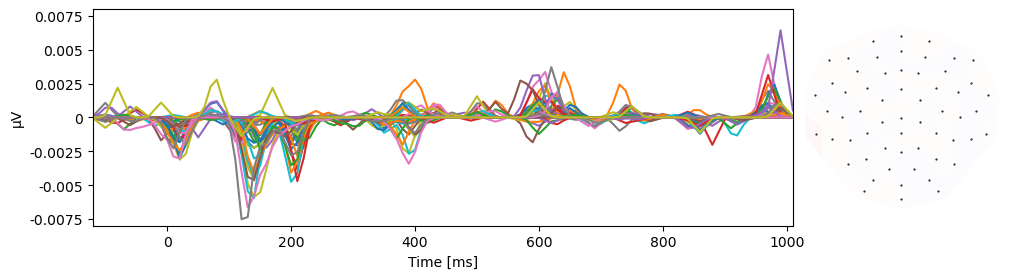

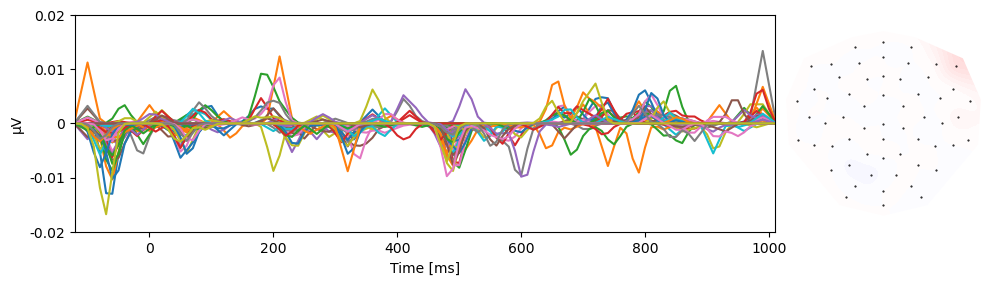

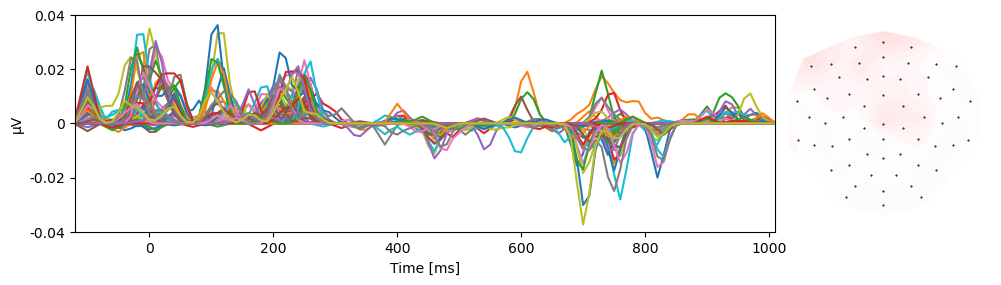

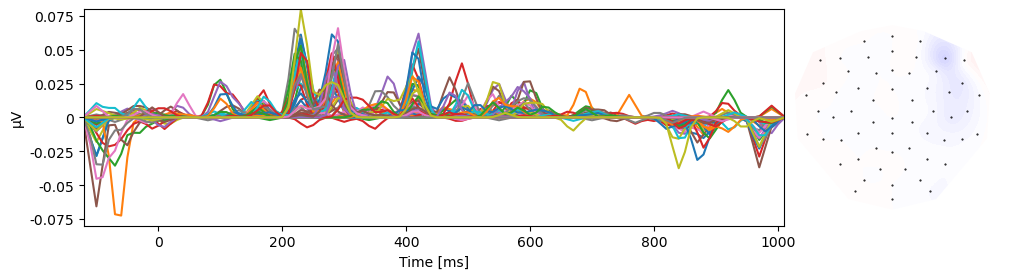

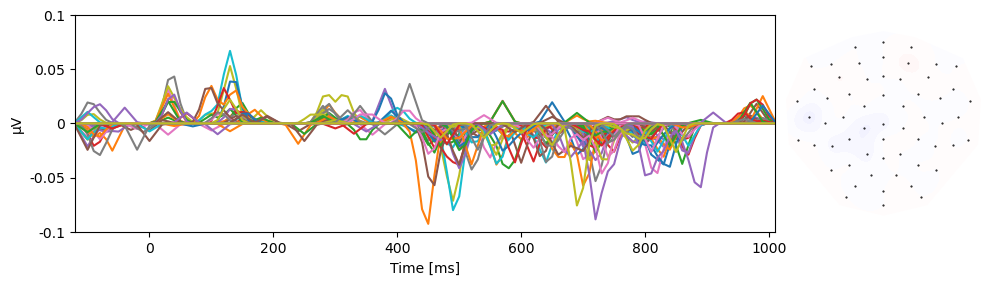

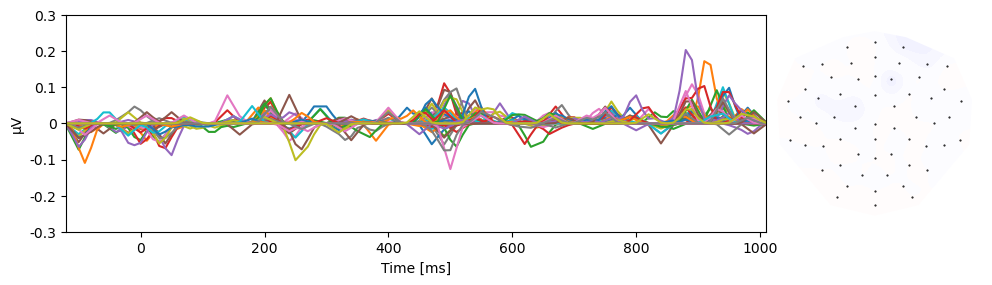

In [8]:
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, gammatone)]

imf_1 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[0])
imf_2 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[1])
imf_3 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[2])
imf_4 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[3])
imf_5 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[4])
imf_6 = eelbrain.load.unpickle(IMF_DIR / IMFsLIST[5])
# Models
# ------
# Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
    # IFs
    'IMF_1':[imf_1],
    'IMF_2':[imf_2],
    'IMF_3':[imf_3],
    'IMF_4':[imf_4],
    'IMF_5':[imf_5],
    'IMF_6':[imf_6],
}
"""
# Acoustic models
'envelope': [envelope],
'envelope+onset': [envelope, onset_envelope],
'acoustic': [gammatone, gammatone_onsets],
# Models with word-onsets and word-class
'words': [word_onsets],
'words+lexical': [word_onsets, word_lexical, word_nlexical],
'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
# Language Models
'Ngram': [word_Ngram, word_onsets, word_lexical, word_nlexical],
'CFG': [word_CFG, word_onsets, word_lexical, word_nlexical],
'Ngram-CFG_all': [word_Ngram, word_CFG, word_onsets, word_lexical, word_nlexical]
# F0 & IF
'IF': [IMFs]
# IFs
    'IMF_1':[imf_1],
    'IMF_2':[imf_2],
    'IMF_3':[imf_3],
    'IMF_4':[imf_4],
    'IMF_5':[imf_5],
    'IMF_6':[imf_6],
"""    
# Estimate TRFs
# -------------
# Loop through subjects to estimate TRFs
for subject in SUBJECTS[:1]:
    subject_trf_dir = TRF_DIR / subject[:3]
    subject_trf_dir.mkdir(exist_ok=True)
    # Generate all TRF paths so we can check whether any new TRFs need to be estimated
    trf_paths = {model: subject_trf_dir / f'{subject[:3]} {model}.pickle' for model in models}
    # Skip this subject if all files already exist
    #if all(path.exists() for path in trf_paths.values()):
        #continue
    # Load the EEG data
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)  # subject /
    # Band-pass filter the raw data between 0.5 and 20 Hz
    raw.filter(0.5, 20)
    # Interpolate bad channels
    raw.interpolate_bads()
    # Extract the events marking the stimulus presentation from the EEG file
    events = eelbrain.load.fiff.events(raw)
    # Not all subjects have all trials; determine which stimuli are present
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events['event']]
    # Extract the EEG data segments corresponding to the stimuli
    trial_durations = [durations[i] for i in trial_indexes]
    eeg = eelbrain.load.fiff.variable_length_epochs(events, -0.100, trial_durations, connectivity='auto')  #, decim=5 #decim=5 meaning to resample to sfreq=100Hz
    # Since trials are of unequal length, we will concatenate them for the TRF estimation.
    eeg_concatenated = eelbrain.concatenate(eeg)
    for model, predictors in models.items():
        path = trf_paths[model]
        # Skip if this file already exists
        #if path.exists():
            #continue
        print(f"Estimating: {subject[:3]} ~ {model}")
        # Select and concetenate the predictors corresponding to the EEG trials
        predictors_concatenated = []
        for predictor in predictors:
            #print(predictor)
            predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))
        print(predictors_concatenated)
        # Fit the mTRF
        trf = eelbrain.boosting(eeg_concatenated, predictors_concatenated, -0.100, 1.000, error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)
        #p = eelbrain.plot.TopoButterfly(trf.h_scaled) # to check the boosted trf is not None
        #p
        
        # Save the TRF for later analysis
        #eelbrain.save.pickle(trf, path)
